In [16]:
from itertools import permutations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox, jarque_bera, normaltest
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from IPython.display import Markdown, display
# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
def printmd(string):
    "prints text in bold"
    display(Markdown(string))

import warnings
warnings.filterwarnings(action="ignore")

In [17]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

house_prices_df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


#### Missing Values

Let us take a look at the missing data:

In [18]:
#count missing values
missing_vals = (house_prices_df.isnull().sum()/len(house_prices_df)).sort_values(ascending=False)

# keep column names that do have them
missing_vals = missing_vals[missing_vals > 0]

printmd("**Missing value percentages:** Total values: {}".format(len(house_prices_df)))
print(missing_vals, '\n')


**Missing value percentages:** Total values: 1460

poolqc         0.995
miscfeature    0.963
alley          0.938
fence          0.808
fireplacequ    0.473
lotfrontage    0.177
garagecond     0.055
garagetype     0.055
garageyrblt    0.055
garagefinish   0.055
garagequal     0.055
bsmtexposure   0.026
bsmtfintype2   0.026
bsmtfintype1   0.025
bsmtcond       0.025
bsmtqual       0.025
masvnrarea     0.005
masvnrtype     0.005
electrical     0.001
dtype: float64 



Let us drop the unnecessary columns based on the missing value percentages. i.e. poolqc, miscfeature, alley, fence, fireplacequ, lotfrontage.

And later perform data cleaning.

In [19]:

# Columns to be dropped
drop_cols = missing_vals[:5].index.to_list()
drop_cols.extend(['id'])

# Columns for data cleaning
data_clean_cols = {'garage':[i for i in missing_vals.index.to_list() if i.startswith('garage')],
                 'basement':[i for i in missing_vals.index.to_list() if i.startswith('bsmt')],
                 'etc':['masvnrarea','masvnrtype','electrical']}

# Drop columns marked for removal and treat the NaN values
house_prices_df.drop(columns=drop_cols, inplace=True)
house_prices_df = house_prices_df.replace([np.inf, -np.inf], np.nan).dropna(how="all")


In [20]:
# Create a dictionary containing the value to replace missing values in each column
fill_with = {'garageyrblt': 0, 'garagequal': 'TA', 'garagecond': 'TA', 'garagefinish': 'Unf','garagetype':'No',
             'bsmtexposure':'No','bsmtfintype2':'Unf','bsmtfintype1':'Unf','bsmtqual':'TA','bsmtcond':'TA',
             'masvnrarea':0,'masvnrtype':'None','electrical':'SBrkr'}
house_prices_df = house_prices_df.fillna(value=fill_with)

In [21]:
def classify_neighborhood(saleprice):
    """ puts houses in preset neighborhood bins """
    
    nbr_class = {0:'saleprice < 120000',
                 1:'saleprice >= 120000 and saleprice < 200000',
                 2:'saleprice >= 200000 and saleprice < 300000',
                 3:'saleprice >= 300000'}
    for class_level in nbr_class.keys():
        if eval(nbr_class[class_level]):
            return class_level

house_prices_df['neighborhood_class'] = house_prices_df['saleprice'].apply(classify_neighborhood)

In [22]:
# Initial model prep
temp_df = house_prices_df[['saleprice','overallqual','grlivarea','garagecars','neighborhood_class']]

def log_prep(temp_df):
    """takes in the chosen temp_df for the model and outputs X & Y with saleprice log-transformed"""
    
    # Log-transform salesprice values & drop saleprice
    temp_df['saleprice_log'] = np.log(temp_df['saleprice'])
    temp_df.drop(columns=['saleprice'],inplace=True)
    
    # designate features
    features = list(temp_df.columns)
    features.remove('saleprice_log')
    print('features (len: {}): {}\ntarget: {}'.format(len(features),{i for i in features},list(set(set(temp_df.columns)-set(features)))))

    # X & Y
    X = temp_df[features]
    Y = temp_df['saleprice_log']
    return X,Y

X, Y = log_prep(temp_df)

features (len: 4): {'neighborhood_class', 'grlivarea', 'overallqual', 'garagecars'}
target: ['saleprice_log']


In [23]:
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


## OLS

In [24]:
temp_df.head(5)

,overallqual,grlivarea,garagecars,neighborhood_class,saleprice_log
0,7,1710,2,2,12.248
1,6,1262,2,1,12.109
2,7,1786,2,2,12.317
3,7,1717,3,1,11.849
4,8,2198,3,2,12.429


In [25]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_log   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     2571.
Date:                Thu, 30 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:58:02   Log-Likelihood:                 757.33
No. Observations:                1168   AIC:                            -1505.
Df Residuals:                    1163   BIC:                            -1479.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 11.0410      0.021    526.281      0.000      11.000      11.082
overallqual            0.0618      0.004     13.968      0.000       0.053       0.070
grlivarea           9.593e-05   9.39e-06     10.213      0.000    7.75e-05       0.000
garagecars             0.0637      0.007      9.581      0.000       0.051       0.077
neighborhood_class     0.2907      0.008     37.601      0.000       0.276       0.306
==============================================================================
Omnibus:                      344.637   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1884.232
Skew:                          -1.253   Prob(JB):                         0.00
Kurtosis:                       8.695   Cond. No.                     9.45e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

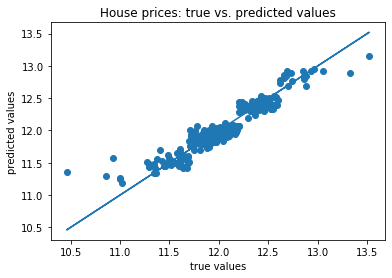

OLS MODEL ERRORS
**********************************
Mean absolute error of the prediction is: 0.10166887563600831
Mean squared error of the prediction is: 0.018753568360448822
Root mean squared error of the prediction is: 0.1369436685664906
Mean absolute percentage error of the prediction is: 0.8515401970633499


In [26]:
# predict house prices using test set
y_preds = results.predict(X_test)
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true vs. predicted values")
plt.show()
print("OLS MODEL ERRORS\n**********************************")
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## KNN

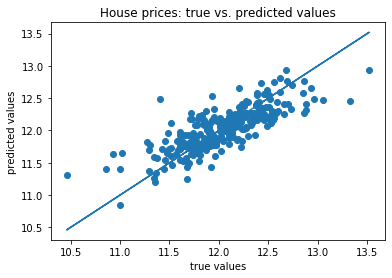

KNN MODEL ERRORS
**********************************
Mean absolute error of the prediction is: 0.18667369346256013
Mean squared error of the prediction is: 0.06173326703769544
Root mean squared error of the prediction is: 0.2484618019690259
Mean absolute percentage error of the prediction is: 1.555641900018148
********************


In [27]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# KNN Regressor
gridOv_params = {'n_neighbors':[6],
                 'weights':['distance'],
                 'algorithm' : ['auto'],
                 'leaf_size':[5],
                 'metric':['euclidean'],
                 'n_jobs':[-1]
                }
knn_results = GridSearchCV(KNeighborsRegressor(),param_grid=gridOv_params,n_jobs=-1)
knn_results.fit(X_train,y_train)
gridOv_params = knn_results.best_params_
knn_results = KNeighborsRegressor(algorithm=gridOv_params['algorithm'],
                           leaf_size=gridOv_params['leaf_size'],
                           metric=gridOv_params['metric'],
                           n_jobs=gridOv_params['n_jobs'],
                           n_neighbors=gridOv_params['n_neighbors'],
                           weights=gridOv_params['weights'])
knn_results.fit(X_train,y_train)

y_preds = knn_results.predict(X_test)

# plot results against actual values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true vs. predicted values")
plt.show()
# Measure model errors
print("KNN MODEL ERRORS\n**********************************")
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))
print(('*'*20))

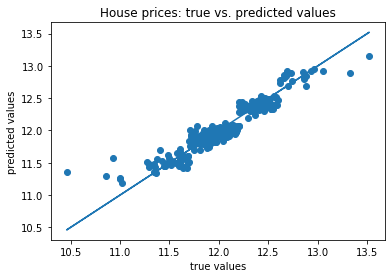

ELASTICNET MODEL ERRORS
**********************************
Mean absolute error of the prediction is: 0.10156825056141441
Mean squared error of the prediction is: 0.018745826552664602
Root mean squared error of the prediction is: 0.13691539925320526
Mean absolute percentage error of the prediction is: 0.8507002093029996


In [30]:
elasticregr = ElasticNet(alpha=0.001, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

# plot results against actual values
plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true vs. predicted values")
plt.show()

print("ELASTICNET MODEL ERRORS\n**********************************")
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))